In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import os
from random import randint
from os import listdir
from os.path import isfile, join

# some cutoffs to play with:
max_invalid_key_pairs = 8
margin = 3
singlefile = False

path_to_datasets = "../datasets/"
path_to_approved = "../datasets/approved/" 
path_to_thrown = "../datasets/thrown_out/" 
protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 
'R-Wr', 'L-Sho', 'L-Elb', 'L-Wr', 
'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip',
 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 
 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44],
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30],
          [47,48], [49,50], [53,54], [51,52], [55,56],
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]




In [2]:
def getKeypoints(probMap, threshold=0.1):

    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []

    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints



In [3]:

# Find valid connections between the different joints of a all persons present
def getValidPairs(output, frameWidth, frameHeight, detected_keypoints):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid

        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ])
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            #print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    return valid_pairs, invalid_pairs




In [4]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
def getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list):
    # the last number in each row is the overall score
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])):
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints


In [5]:
def perform_keypoint_analysis(filename, single=False):
    print(filename)
    image1 = cv2.imread(filename)
    
    frameWidth = image1.shape[1]
    frameHeight = image1.shape[0]

    t = time.time()
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                            (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()
    print("Time Taken in forward pass = {}".format(time.time() - t))

    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
        keypoints = getKeypoints(probMap, threshold)
        if(single):
            print("{}. Keypoints - {} : {}".format(part, keypointsMapping[part], keypoints))
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1

        detected_keypoints.append(keypoints_with_id)

    frameClone = image1.copy()
    for i in range(nPoints):
        for j in range(len(detected_keypoints[i])):
            cv2.circle(frameClone, detected_keypoints[i][j][0:2], 5, colors[i], -1, cv2.LINE_AA)
    #cv2.imshow("Keypoints",frameClone)

    valid_pairs, invalid_pairs = getValidPairs(output, frameWidth, frameHeight, detected_keypoints)

    personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list)
    
    for i in range(17):
        for n in range(len(personwiseKeypoints)):
            index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
            if -1 in index:
                continue
            B = np.int32(keypoints_list[index.astype(int), 0])
            A = np.int32(keypoints_list[index.astype(int), 1])
            cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
            


    return detected_keypoints, frameClone, image1
    #cv2.waitKey(0)



In [6]:

def classify_file(filename, single=True, subfolder = ""):
    detected_keypoints, frameClone, image = perform_keypoint_analysis(filename, single)
    missing = []
    found = []
    split_name = filename.split("/")
    isolated_filename = ""
    for el in split_name:
        if(".jpg" in el or ".png" in el):
            isolated_filename = el
    if isolated_filename is "":
        print("Bad filename given: " + filename)
        return None
    print("File: " + filename)
    i = 0
    for el in detected_keypoints:
        if el == []:
            missing.append(i)
        else:
            found.append(i)
        i += 1
    if single:
        print("\tnumber of missing pairs: " + str(len(missing)))
        print("\tnumber of detected pairs: " + str(len(found)))

    print("~~~~~~~~~~~~~~~~~~~~")
    titleobj = ""
    title_color = ""
    passed_filter = apply_filter(missing)
    if(single or passed_filter is False):
        plt.figure(figsize=[15,15])
        plt.imshow(frameClone[:,:,[2,1,0]])
    if passed_filter is False:
        savedname = path_to_datasets + "thrown_out/" + subfolder + "/" + isolated_filename
        # if we're classifying folders, we need to save the images into approved or thrown_out
        if single is False:
            if cv2.imwrite(savedname, image) is False: #change image1 to frameClone to write the image with keypoints on top
                print("couldnt save image as: " + savedname)
        titleobj = filename + ": Thrown Out"
        title_color = "r"
    
    else:
        savedname = path_to_datasets + "approved/" + subfolder + "/" + isolated_filename
        print(savedname)
        if single is False:
            if cv2.imwrite(savedname , image) is False:#change image1 to frameClone to write the image with keypoints on top
                print("couldnt save image as: " + savedname)
        titleobj = filename + ": Approved"
        title_color = "g"
    if single or passed_filter is False:
        title_obj = plt.title(titleobj) #get the title property handler
        plt.setp(title_obj, color=title_color)

    if passed_filter is False:
        print("File does NOT pass filter.")
        return False, detected_keypoints
    else:
        print("File does pass filter.")
        return True, detected_keypoints

In [7]:
# returns true if passed filter, false if not
def apply_filter(invalid):
    '''
        keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 
        'R-Wr', 'L-Sho', 'L-Elb', 'L-Wr', 
        'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip',
         'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 
         'R-Ear', 'L-Ear']

        POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
                      [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
                      [1,0], [0,14], [14,16], [0,15], [15,17],
                      [2,17], [5,16] ]
    '''
    
    '''
    for each list, you need at least one keypoint:
    [r-eye, l-eye, 'r-ear', 'l-ear']
    [r-elb, r-wr]
    [l-elb, l-wr]
    
    need all:
    [l-ank, r-ank]
    '''
    # set up lists of keypoints that must not be in the invalid list
    required_keypoints = []
    group_keypoints = []
    
    # required keypoints
    for item in ["L-Ank", "R-Ank", "R-Wr", "L-Wr"]:
        required_keypoints.append(keypointsMapping.index(item))
    # group required keypoints (req. one from each group at least)
    for outer in [['R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']]:
        to_append = []
        for inner in outer:
            to_append.append(keypointsMapping.index(inner))
        group_keypoints.append(to_append)
        
    #print(required_keypoints)
    #print(group_keypoints)
    
    # now check if the required ones are all there
    for req_kp in required_keypoints:
        if req_kp in invalid:
            #print("doesnt have kp " + str(req_kp) + "(" + keypointsMapping[req_kp] + ")")
            return False
        #else:
            #print("has kp " + str(req_kp) + "(" + keypointsMapping[req_kp] + ")")
    
    # now check that at least one of each list for minimum_keypoints is not in invalid
    for kp_set in group_keypoints:
        kp_valid = [i for i in kp_set if i not in invalid]
        if len(kp_valid) < 1:
            return False
    return True
        


In [8]:
def classify_folder(foldername, setname):
    path_to_folder = path_to_datasets + setname + "/" + foldername + "/"

    if os.path.isdir(path_to_folder) is False:
        print(foldername + " is not a folder.")
        return None
    try:
        os.mkdir(path_to_approved + foldername)
    except OSError:
        print("couldn't make approved subfolder (might already exist)")
        
        
        pass
    try:
        os.mkdir(path_to_thrown + foldername)
    except OSError:
        print("couldn't make thrown out subfolder (might already exist)")
        pass
    onlyfiles = [path_to_folder + f for f in listdir(path_to_folder) if (isfile(join(path_to_folder, f)) and (".jpg" in f or ".png" in f))]
    good_files = []
    bad_files = []
    #onlyfiles = onlyfiles[0:5]
    for filename in onlyfiles:
        passed_filter, detected_keypoints = classify_file(filename, False, foldername)
        if passed_filter is False:
            bad_files.append(filename)
        else:
            good_files.append(filename)
        
    print("# FILES ACCEPTED " + path_to_folder + ": " + str(len(good_files)) + "\n# NOT ACCEPTED: " + str(len(bad_files)))
    #print("accepted: \n")
    #print(good_files)
    #print("\n\nnot accepted:")
    if(len(bad_files) > 0):
        print(bad_files)




../datasets/training_set/bridge/File1.jpg
Time Taken in forward pass = 2.263674259185791
0. Keypoints - Nose : [(3523, 1454, 0.59324586)]
1. Keypoints - Neck : [(3215, 1332, 0.3851539)]
2. Keypoints - R-Sho : [(3400, 1578, 0.27583465)]
3. Keypoints - R-Elb : []
4. Keypoints - R-Wr : []
5. Keypoints - L-Sho : [(3399, 1640, 0.20159759), (3093, 1145, 0.20802622)]
6. Keypoints - L-Elb : [(2910, 1950, 0.24574426)]
7. Keypoints - L-Wr : [(2479, 2259, 0.30738616)]
8. Keypoints - R-Hip : []
9. Keypoints - R-Knee : [(1255, 649, 0.11216019)]
10. Keypoints - R-Ank : [(949, 2136, 0.20192823)]
11. Keypoints - L-Hip : []
12. Keypoints - L-Knee : [(1255, 650, 0.13699657)]
13. Keypoints - L-Ank : [(1010, 2135, 0.159668)]
14. Keypoints - R-Eye : [(3583, 1393, 0.6479478)]
15. Keypoints - L-Eye : [(3583, 1455, 0.2807145)]
16. Keypoints - R-Ear : [(3583, 1269, 0.35229343)]
17. Keypoints - L-Ear : []
File: ../datasets/training_set/bridge/File1.jpg
	number of missing pairs: 5
	number of detected pairs: 13
~

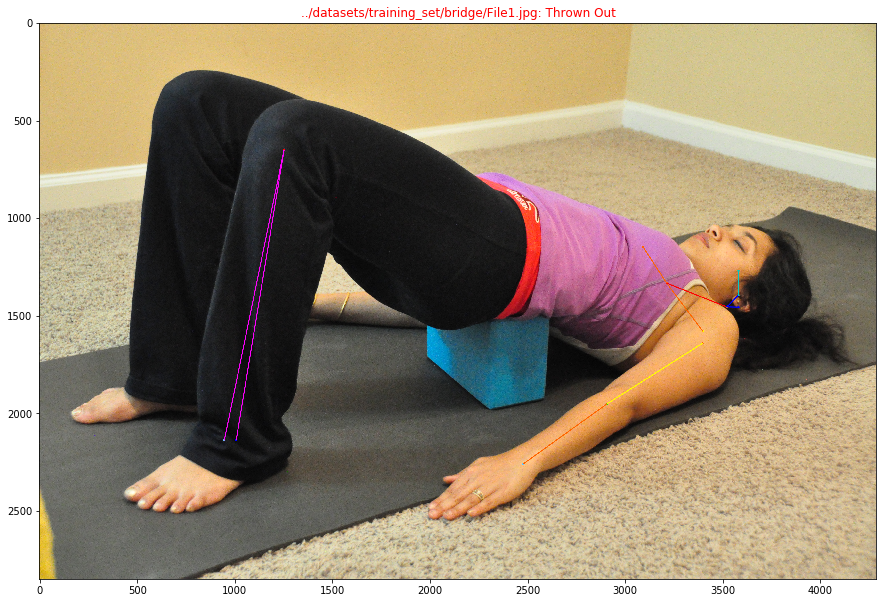

In [14]:
_ = classify_file(path_to_datasets + "training_set/bridge/File1.jpg")


In [10]:
classify_folder("warrior2", "training_set")
print("DONE.")

couldn't make approved subfolder (might already exist)
couldn't make thrown out subfolder (might already exist)
../datasets/training_set/warrior2/File46.jpg
Time Taken in forward pass = 2.366891860961914
File: ../datasets/training_set/warrior2/File46.jpg
~~~~~~~~~~~~~~~~~~~~
../datasets/approved/warrior2/File46.jpg
File does pass filter.
../datasets/training_set/warrior2/File47.jpg
Time Taken in forward pass = 2.2295479774475098
File: ../datasets/training_set/warrior2/File47.jpg
~~~~~~~~~~~~~~~~~~~~
../datasets/approved/warrior2/File47.jpg
File does pass filter.
../datasets/training_set/warrior2/File53.png
Time Taken in forward pass = 1.3986239433288574
File: ../datasets/training_set/warrior2/File53.png
~~~~~~~~~~~~~~~~~~~~
../datasets/approved/warrior2/File53.png
File does pass filter.
../datasets/training_set/warrior2/File51.jpg
Time Taken in forward pass = 1.313965082168579
File: ../datasets/training_set/warrior2/File51.jpg
~~~~~~~~~~~~~~~~~~~~
../datasets/approved/warrior2/File51.j

KeyboardInterrupt: 

In [ ]:
print(path_to_datasets)